In [1]:
dataset <- "Dext3r" # Dext3r has all the series. They should be integrated, however
state <- "Emilia-Romagna"
match_dist <- 10000
new_dataset <- "ER"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
metadata <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect() |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata, match_dist, conns$stations)

data <- query_checkpoint_data(dataset, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db)
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"))


In [5]:
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("series_id"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, "Dext3r", desc(dataset), desc(sensor_last))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 10L, 0.5)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))
i

pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>


In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 1)
db <- merged_checkpoint(merge_results, metadata, new_dataset)
rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2062003,110.2,3618225,193.3,NA,3618225,193.3
Vcells,21195059,161.8,116906780,892.0,16384,146127289,1114.9


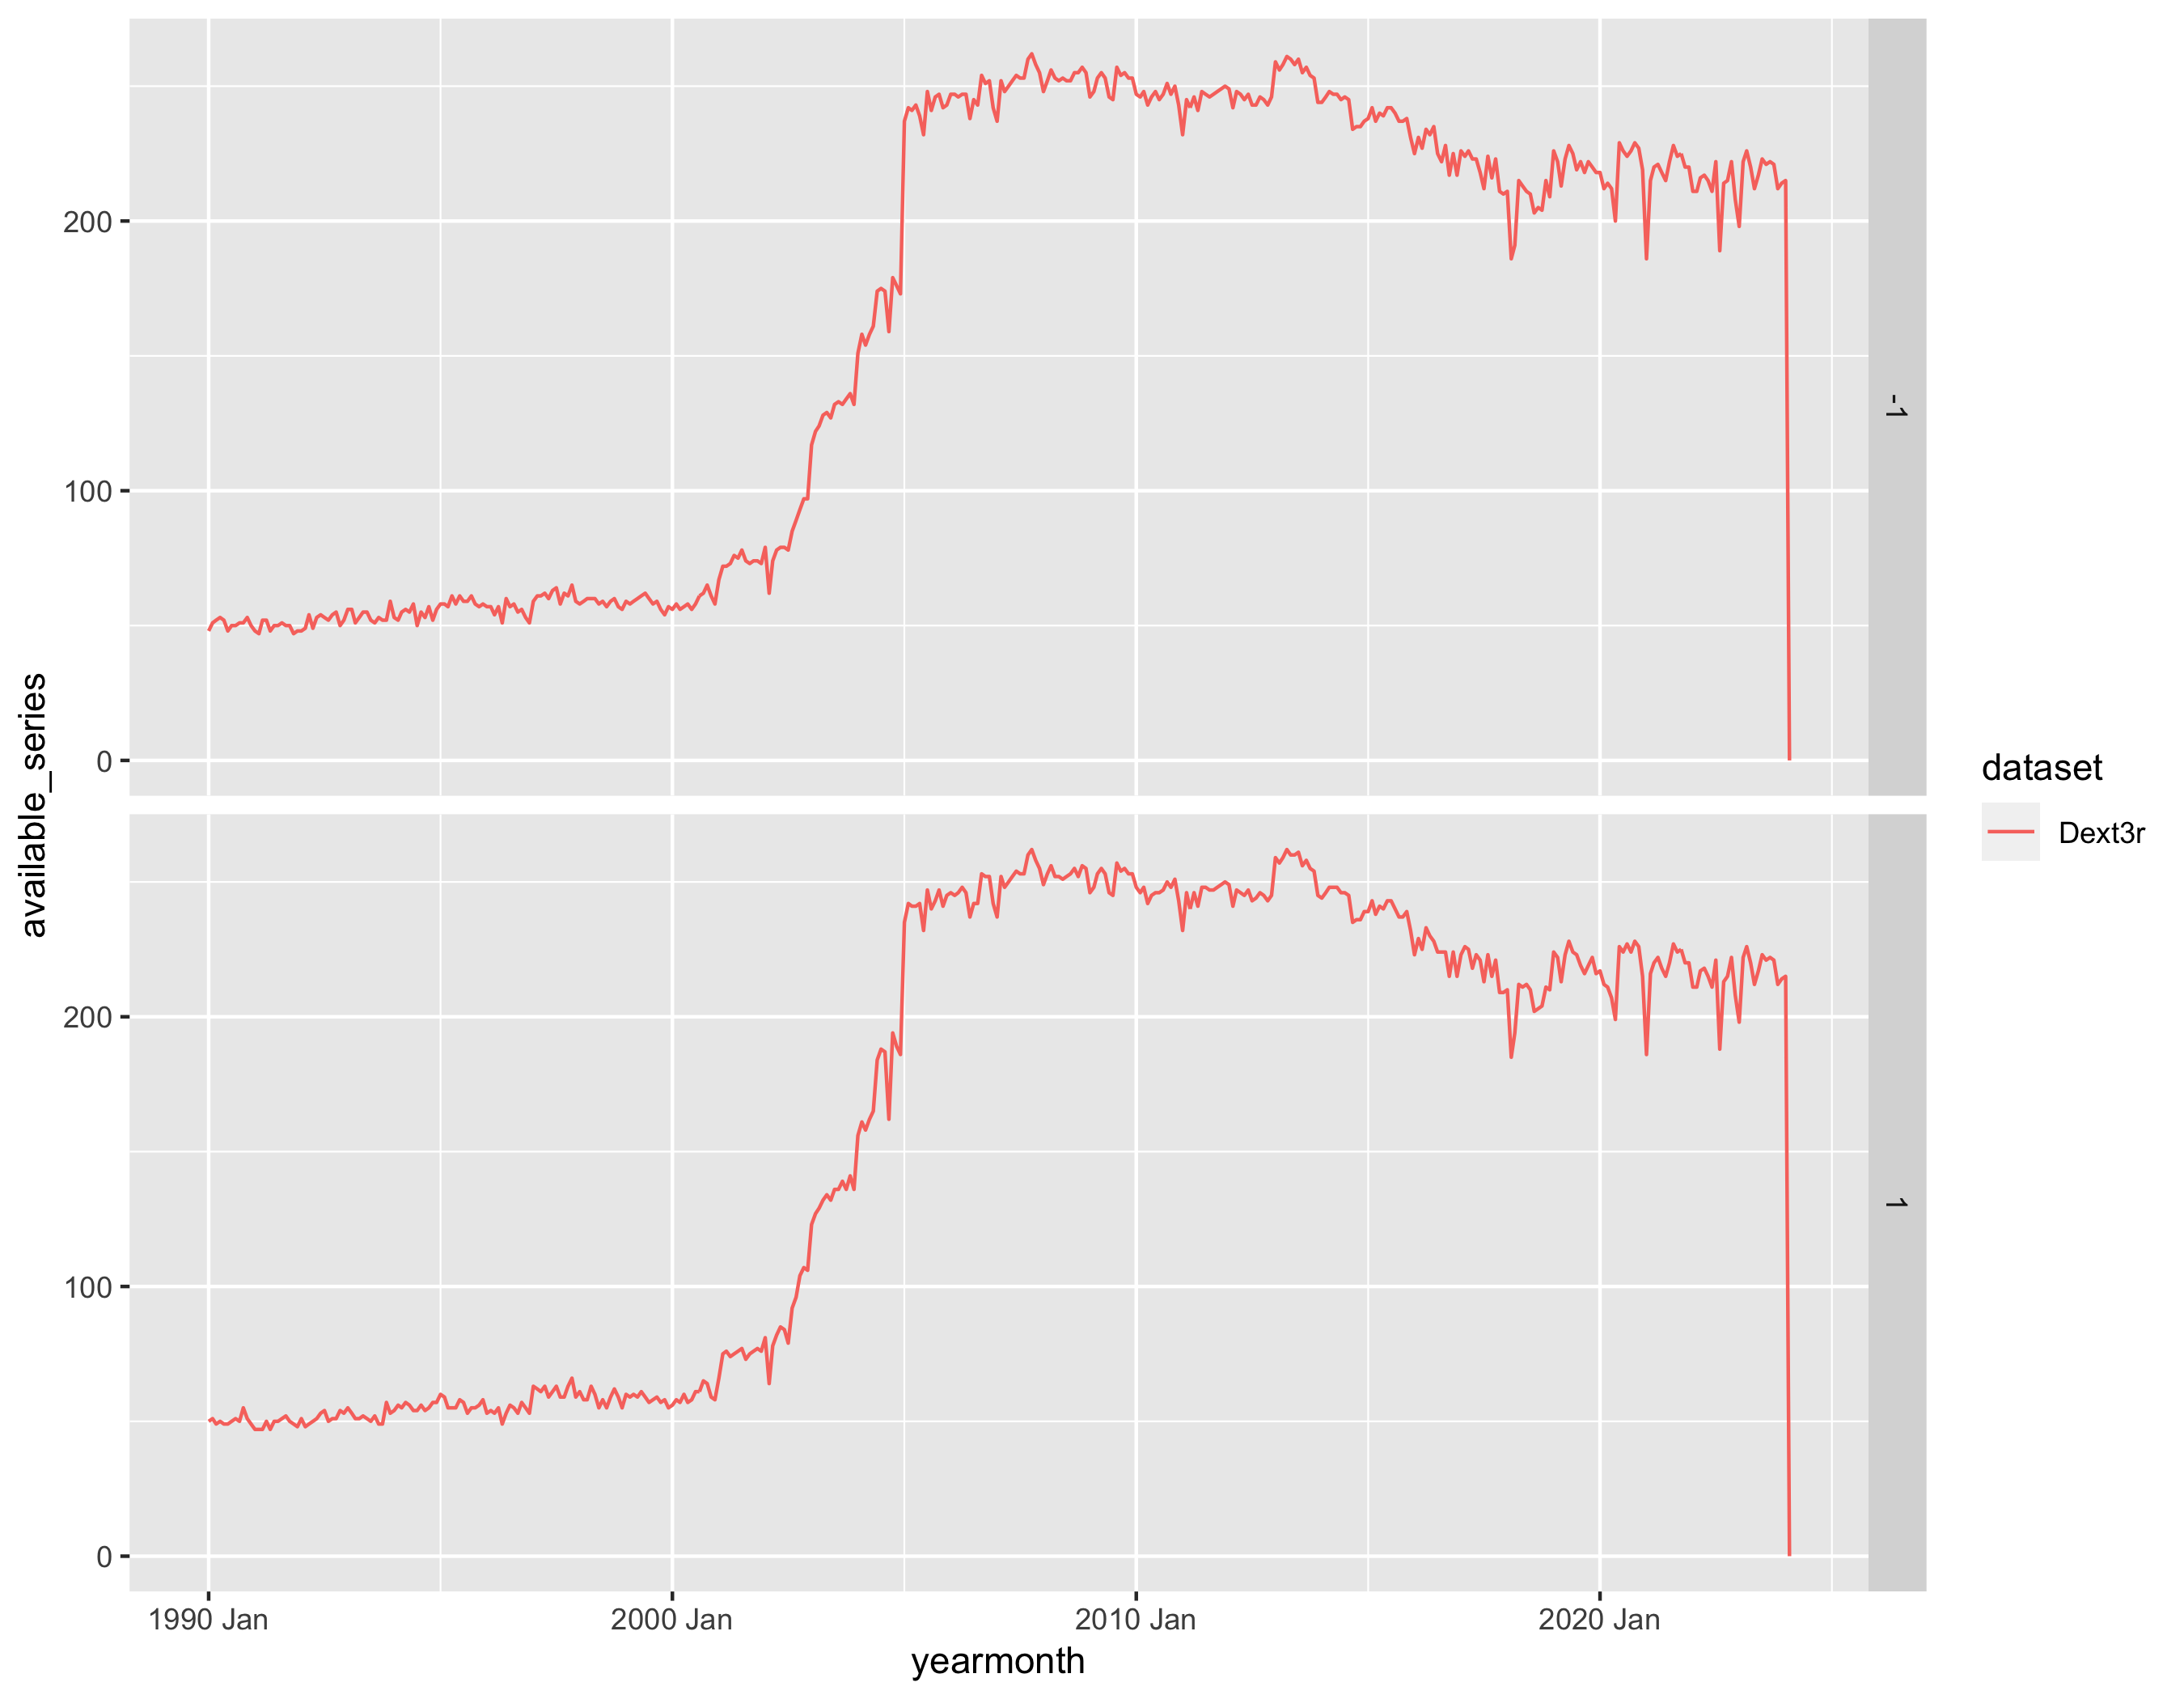

In [9]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt)
pd$plot + facet_grid(variable ~ .)


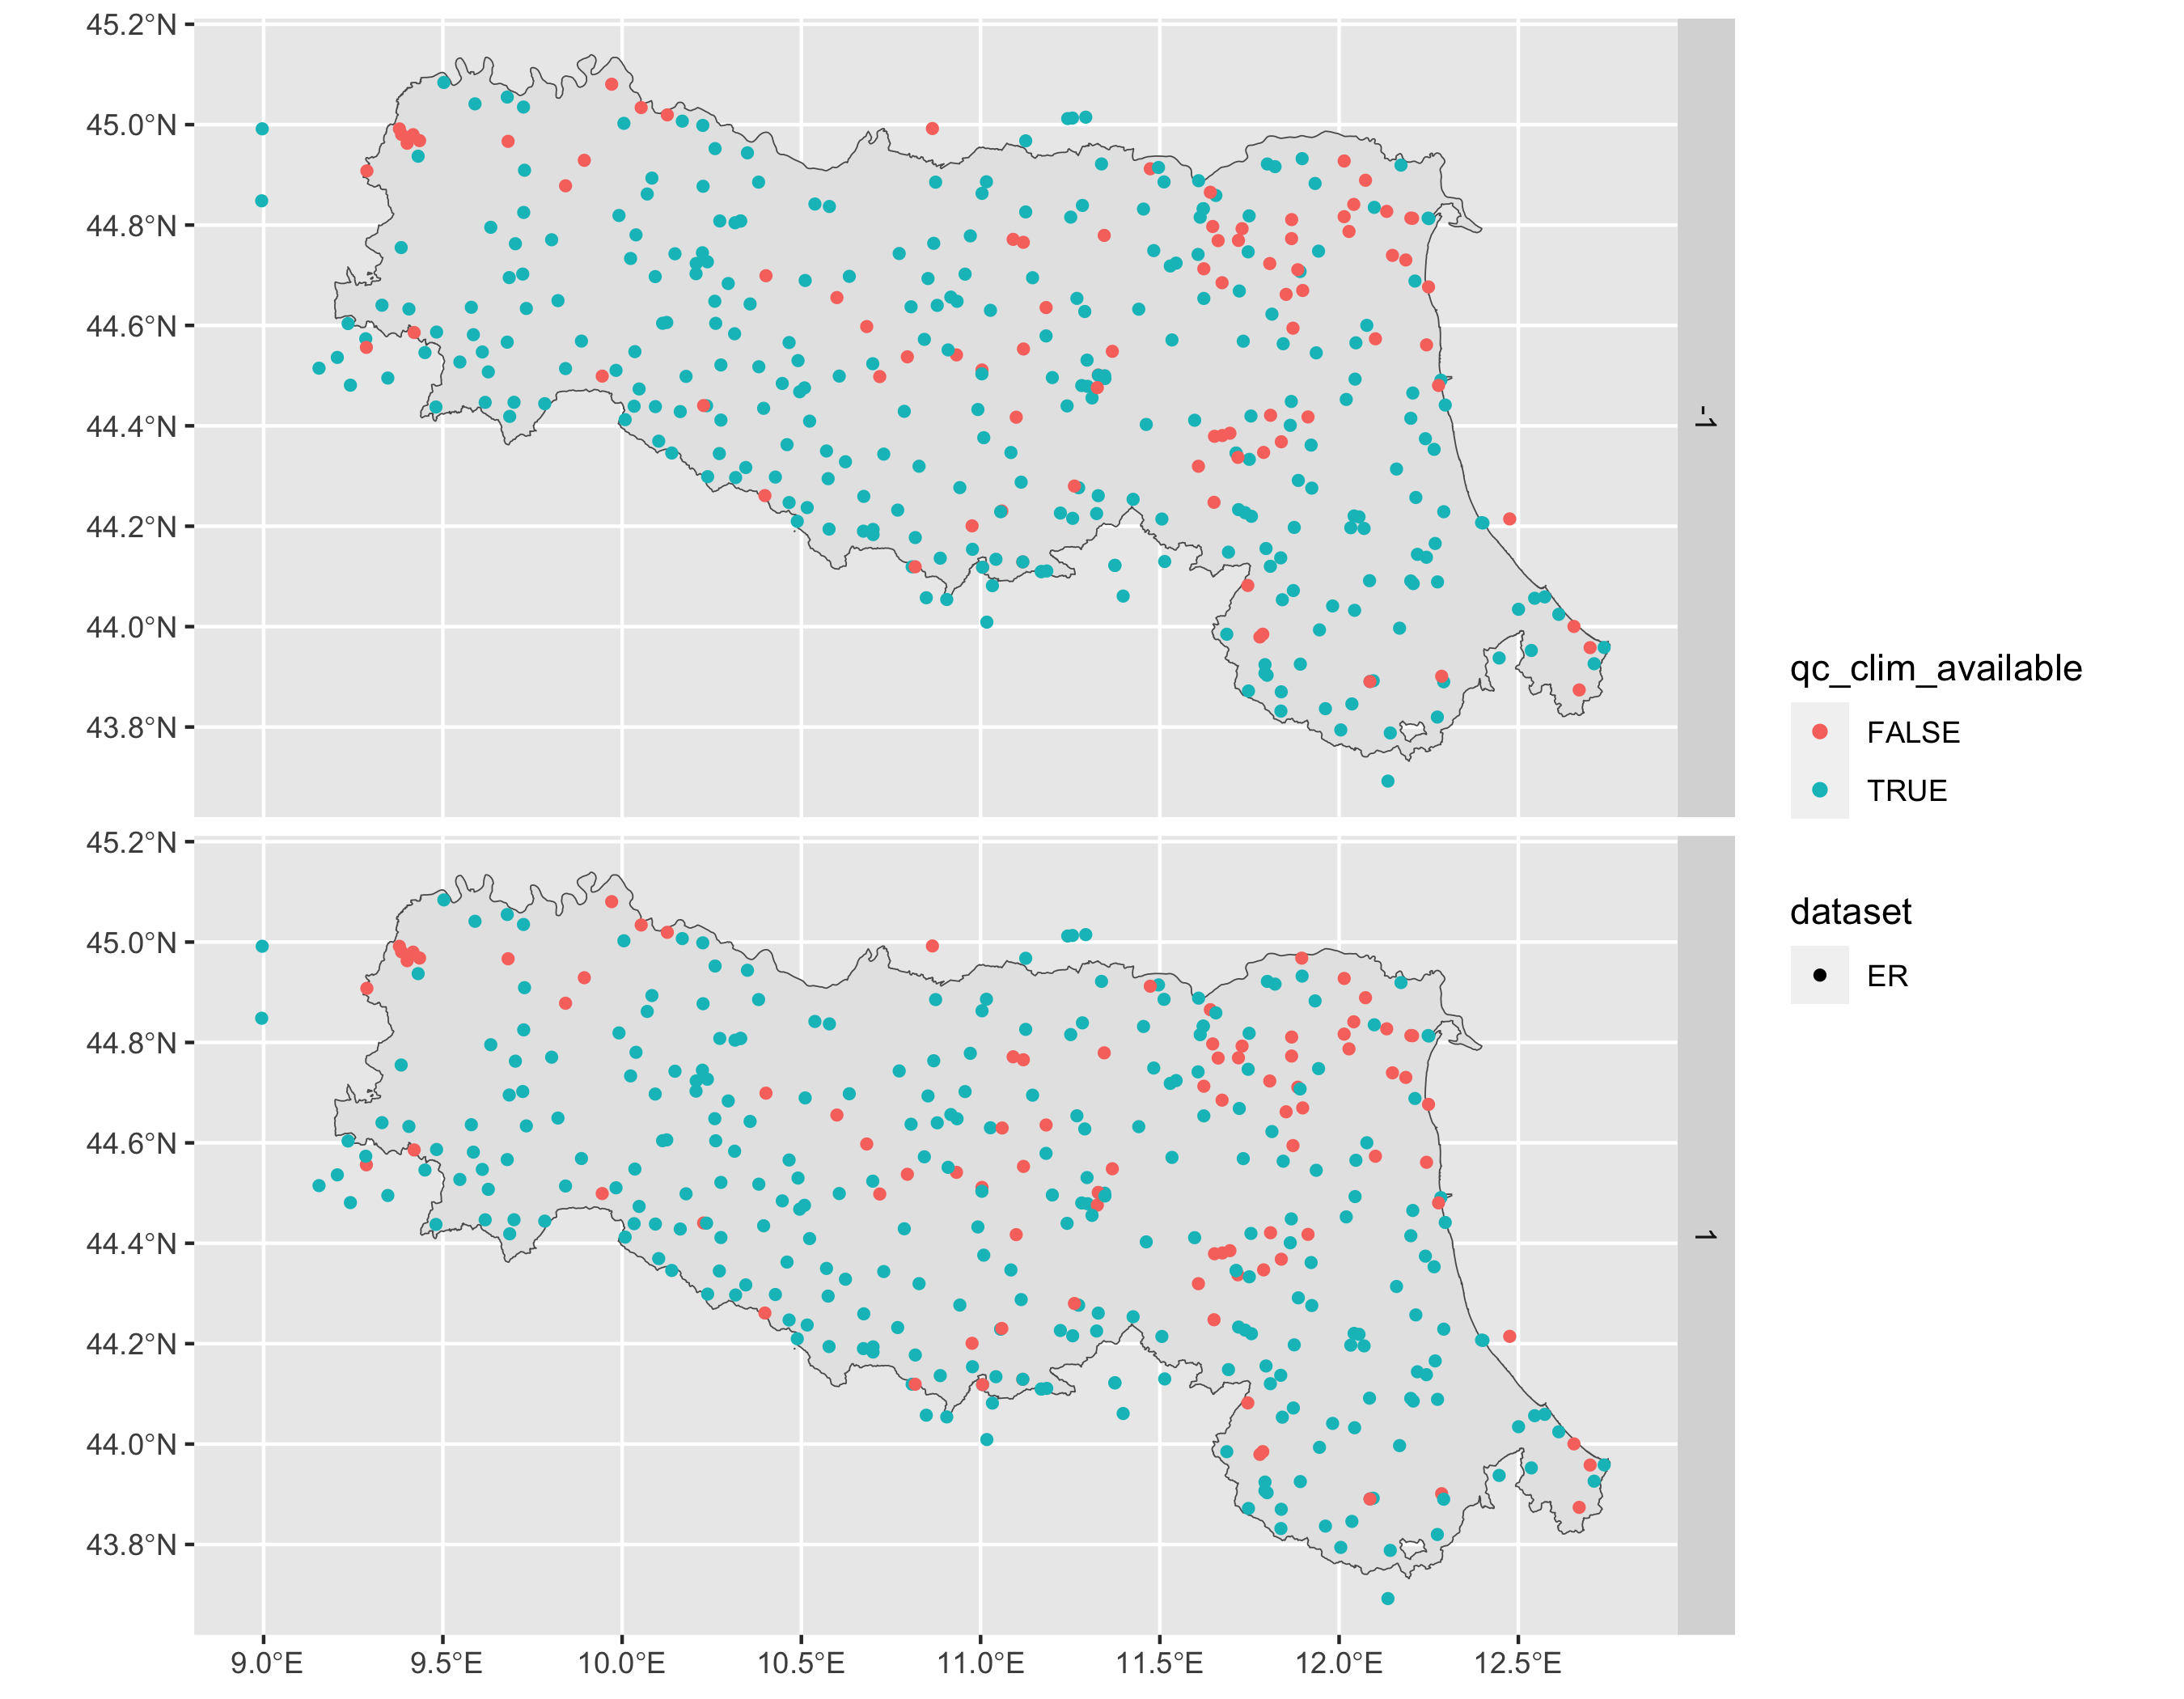

In [10]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot + facet_grid(variable ~ .)


In [11]:
pd$data |>
    group_by(qc_clim_available, variable) |>
    count() |>
    arrange(qc_clim_available, variable)


qc_clim_available,variable,n
<lgl>,<int>,<int>
FALSE,-1,88
FALSE,1,90
TRUE,-1,294
TRUE,1,294


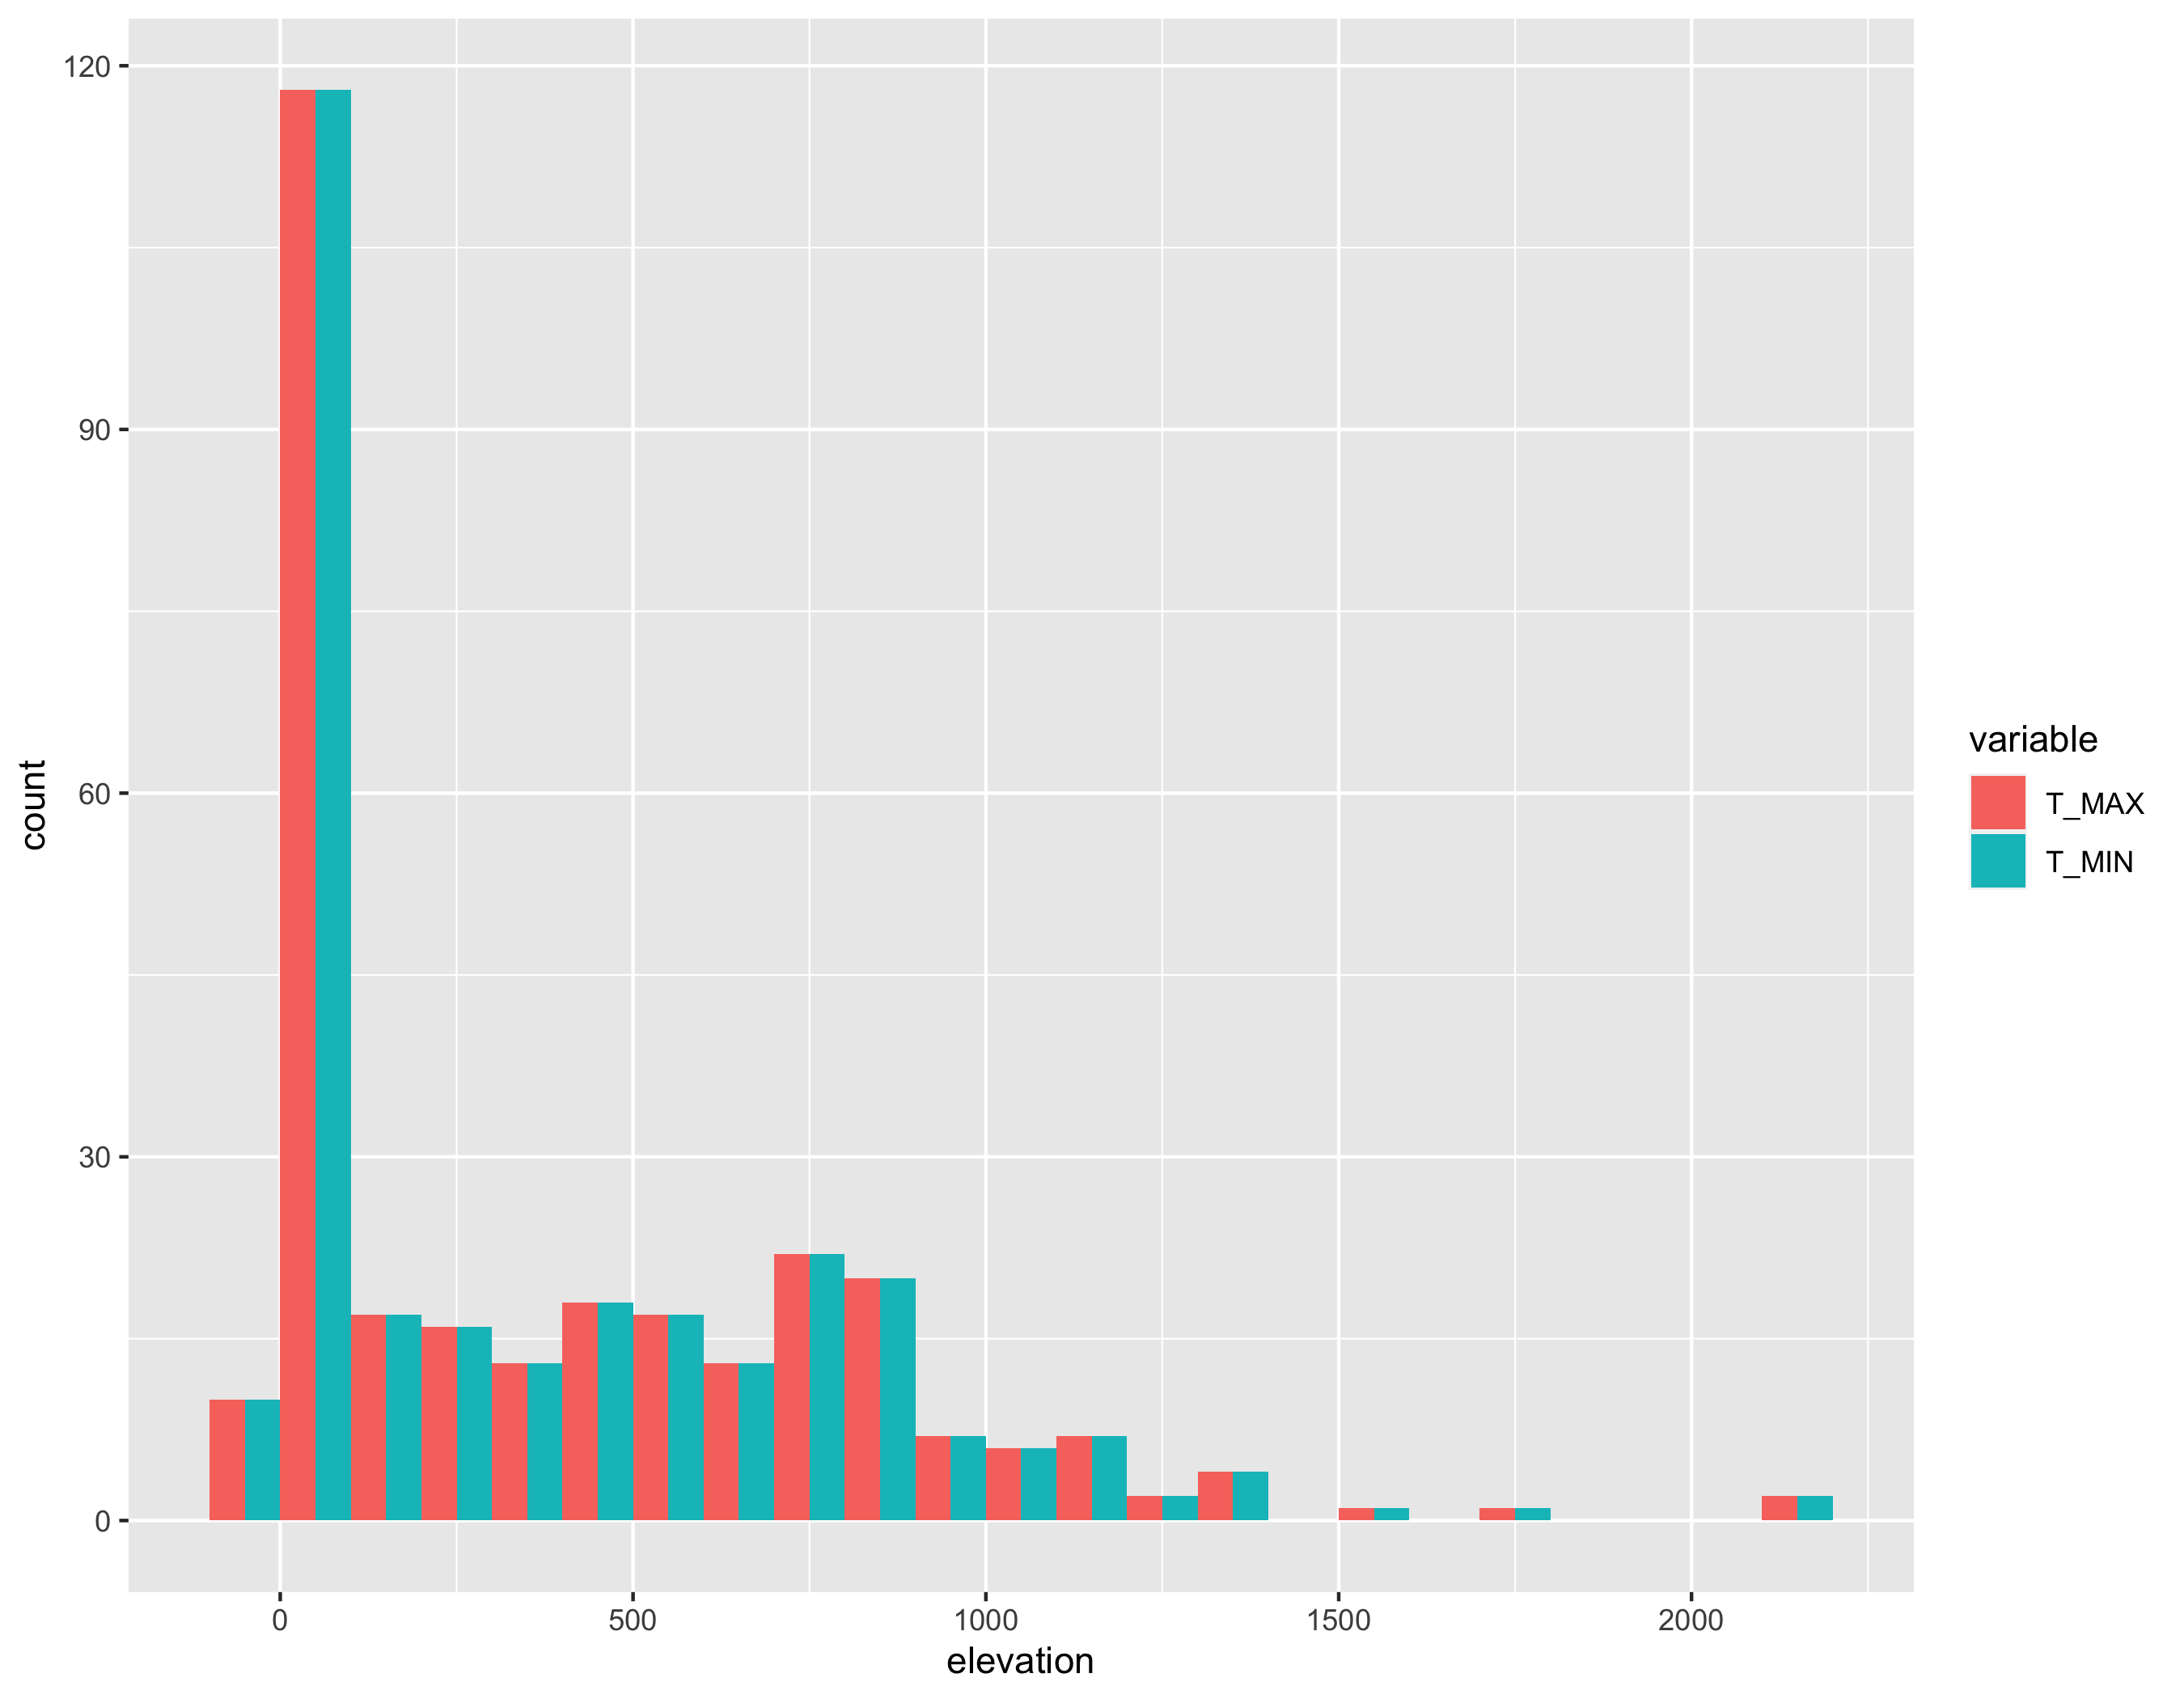

In [12]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())